# Schrödinger's Smoke - an Eulerian simulation of a time-dependent, rotational, inviscid and incompressible flow

<a id="Introduction"></a>
## Introduction

The general problem of a time-dependent, rotational, inviscid and incompressible flow over an $n$-dimensional manifold ${\mathcal{M}\subseteq\mathbb{R}^n}$ is to solve the *incompressible Euler equations* over a vector field ${\textbf{u}(t, \textbf{r})}$ and scalar field ${p(t, \textbf{r})}$, given some initial conditions:

<a id="eqn1"></a>
$$
\begin{cases} \quad\dfrac{\partial \textbf{u}}{\partial t} \,+\, \left(\textbf{u}\cdot\nabla\right)\textbf{u} \; = \; -\nabla p \\[8pt] \quad\nabla\cdot\textbf{u} \; = \; 0 \end{cases}\tag{1}
$$

where ${\textbf{u}: \mathbb{R}\times\mathcal{M}\rightarrow\mathbb{R}^n}$ can be interpreted as the flow velocity vector and ${p: \mathbb{R}\times\mathcal{M}\rightarrow\mathbb{R}}$ can be interpreted as the pressure (scaled by density).<sup>[[1]](#ref01)</sup> This is known to be a generally difficult problem to solve analytically, due to the presence of the nonlinear advective term ${\left(\textbf{u}\cdot\nabla\right)\textbf{u}}$; this nonlinearity can also introduce difficulties into numerical simulations, especially if a naïve approach is taken.

Although the nonlinear term can be avoided (or rather mitigated) by computing within a Lagrangian framework, wherein simulation elements are advected together with the flow,<sup>[[2]](#ref02)</sup> numerical simulations over the Eulerian framework remain popular owing to their greater ease in enforcing boundary conditions and translation into spatial behaviour, e.g. for visual effects.<sup>[[3]](#ref03)[[4]](#ref04)</sup>

In this report, we consider a novel algorithmic approach known as "Schrödinger's Smoke", developed by [[Chern et al. 2016]](#ref03), for a purely Eulerian simulation of an inviscid and incompressible fluid; this algorithm is based on a representation of the fluid as a ${\mathbb{C}^2}$ wavefunction evolving under the Schrödinger equation, and is generally stable and well-behaved for a large range of initial parameters. While this report will generally focus on the simulation of two-dimensional fluids over periodic boundary conditions (equivalent to solving [eqns. (1)](#eqn1) over a torus), this algorithm can be easily extended to any combination of boundary conditions within any number of dimensions.

[Section 1](#sec1) covers the background behind the difficulties of simulating inviscid incompressible flows (IIF) in the Eulerian framework, including a discussion of the flaws encountered by a naïve approach. [Section 2](#sec2) discusses the "Schrödinger's Smoke" algorithm in the simplest case of a periodic rectangular domain, while [section 3](#sec3) elaborates on the possible constraints, boundary conditions, and other complications/extensions that may be added to the algorithm. Lastly [section 4](#sec4) provides a proof-of-concept of the algorithm functioning in three dimensions.

<a id="sec1"></a>
## 1. Background

At face value, one might directly compute the evolution of the ${\textbf{u}(t, \textbf{r})}$ and ${p(t, \textbf{r})}$ fields by directly integrating:

$$
\begin{cases} \quad\dfrac{\partial \textbf{u}}{\partial t} \; = \; -\,\left(\textbf{u}\cdot\nabla\right)\textbf{u}\, -\,\nabla p \\[5pt] \quad\dfrac{\partial p}{\partial t} \; = \;\, ??? \end{cases}
$$

however we see that we do not have an explicit expression for the evolution of the pressure field $p$. Indeed, in the context of IIF, the pressure field in fact acts as a 'constraint field', whose value at all space and time is exactly such that ${\nabla\cdot\textbf{u}=0}$. This raises a problem for naïve time-integration, since the value of the pressure field at a time ${t + dt}$ cannot be calculated explicitly from the state at time $t$, and an implicit solution is difficult to find considering the nonlinear term in the first equation.

<a id="sec11"></a>
### 1.1. Weakly-Compressible Polytropic Fluid

One method of artificially introducing a pressure evolution into the equations is to consider a compressible fluid with non-constant density $\rho$, which may or may not be a function of the pressure; such a fluid obeys the *compressible Euler equations*:

<a id="eqn2a"></a>
$$
\begin{cases} \quad\dfrac{\partial \textbf{u}}{\partial t} \,+\, \left(\textbf{u}\cdot\nabla\right)\textbf{u} \; = \; -\,\dfrac{1}{\rho}\nabla p \\[5pt] \quad\nabla\cdot\left(\rho\textbf{u}\right) \; = \; -\,\dfrac{\partial\rho}{\partial t} \end{cases}\tag{2a}
$$

In the special case of a polytropic fluid, with density ${\rho = p^{\alpha}}$ (against a 'background' of ${\rho_0 = p_0 = 1}$), the incompressible limit is achieved as ${\alpha \rightarrow 0^+}$:

<a id="eqn2b"></a>
$$
\begin{cases} \quad\dfrac{\partial \textbf{u}}{\partial t} \; = \; -\left(\textbf{u}\cdot\nabla\right)\textbf{u} \;-\; p^{-\alpha} \nabla p \\[5pt] \quad\dfrac{\partial p}{\partial t} \; = \; -\, \dfrac{p}{\alpha}\nabla\cdot\textbf{u} \;-\; \textbf{u}\cdot\nabla p \end{cases}\tag{2b}
$$

which nicely presents evolution equations for all fields. It is clear that, under the mathematical limit ${\alpha \rightarrow 0^+}$, the only way to maintain well-behaved fields is that ${\nabla\cdot\textbf{u}\rightarrow 0}$, thus proving that the analytic solutions to the weakly-compressible flows converge to those of the incompressible flow. Unfortunately this analytic equivalence does not translate to a numerical one; in practice this limit is badly-behaved, as shown by the code snippet below.

<IPython.core.display.Javascript object>


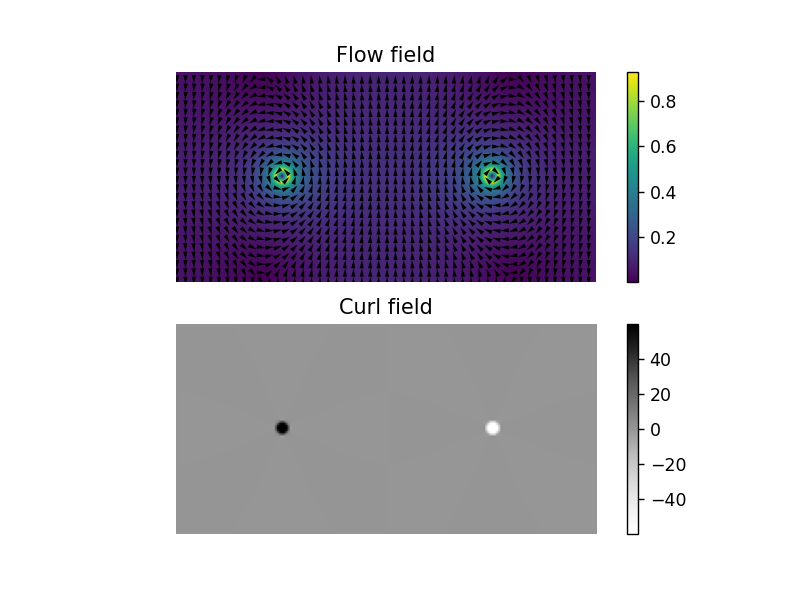

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import ssmoke.visualizer as visual

#----------------------------------------------------------------------------------------------------
# Definitions for the simulation (a 2x1 rectangle)
Nx, Ny = (200, 100)
L = 1
dx, dy = (2*L/Nx, L/Ny)
rmin = np.sqrt(9 * dx * dy)

#----------------------------------------------------------------------------------------------------
# Helper functions for defining the initial state

def vortex(x, y, x0, y0, vort): # Velocity and rel. pressure function for vortex at (x0, y0)
    rsq = (x - x0)**2 + (y - y0)**2
    rminsq = rmin**2
    if rsq > rminsq:
        return (vort * (y0 - y) / rsq, vort * (x - x0) / rsq, -vort**2 / (2 * rsq))
    return (vort * (y0 - y) / rminsq, vort * (x - x0) / rminsq, vort**2 * ((rsq / (2 * rminsq)) - 1) / rminsq)

def init_func(x, y): # Velocity and abs. pressure function for two vortices (with periodic boundaries)
    n_sum = 3
    outx, outy, outp = (0, 0, 1)
    for i in range(-n_sum, n_sum+1):
        for j in range(-n_sum, n_sum+1):
            left = vortex(x, y, (2*i + 0.5)*L, (j + 0.5)*L, 0.9 * rmin)
            right = vortex(x, y, (2*i + 1.5)*L, (j + 0.5)*L, -0.9 * rmin)
            outx += left[0] + right[0]
            outy += left[1] + right[1]
            outp += left[2] + right[2]
    return (outx, outy, outp)

#----------------------------------------------------------------------------------------------------
# Initial state
ux = np.empty((Nx, Ny), dtype=float)
uy = np.empty((Nx, Ny), dtype=float)
p = np.empty((Nx, Ny), dtype=float)
for i in range(Nx):
    for j in range(Ny):
        ux[i,j], uy[i,j], p[i,j] = init_func(i * dx, j * dy)

xcoords, ycoords = np.meshgrid([i * dx for i in range(Nx)], [j * dy for j in range(Ny)], indexing='ij')
ax = visual.image_2d_magcurl_raw(xcoords, ycoords, ux, uy)
plt.show()

As shown the test initial condition comprises of two counter-rotating vortices with small but finite rotational cores, in a two-dimensional rectangular box with periodic boundary conditions; this is not a precise solution of the Euler equations, but does approximately resemble the exact solution for 'ideal' vortices. In this case the vortices' core sizes and strengths are chosen so that the pressure at the center of the vortex is positive, in order to prevent zero pressure and thus zero density regions from occuring. We can test the robustness of the integrator by monitoring the total squared velocity deviation $\int|\textbf{u}(t,\textbf{r})-\textbf{u}(0,\textbf{r})|^2\text{d}^2\textbf{r}$, which should be constant in time and nearly zero since the vortices are (theoretically) stable:

alpha = 0.125 terminated early at step 10 due to RuntimeWarning.
alpha = 0.25 terminated early at step 10 due to RuntimeWarning.
alpha = 0.5 terminated early at step 12 due to RuntimeWarning.
alpha = 1.0 terminated early at step 13 due to RuntimeWarning.


<IPython.core.display.Javascript object>


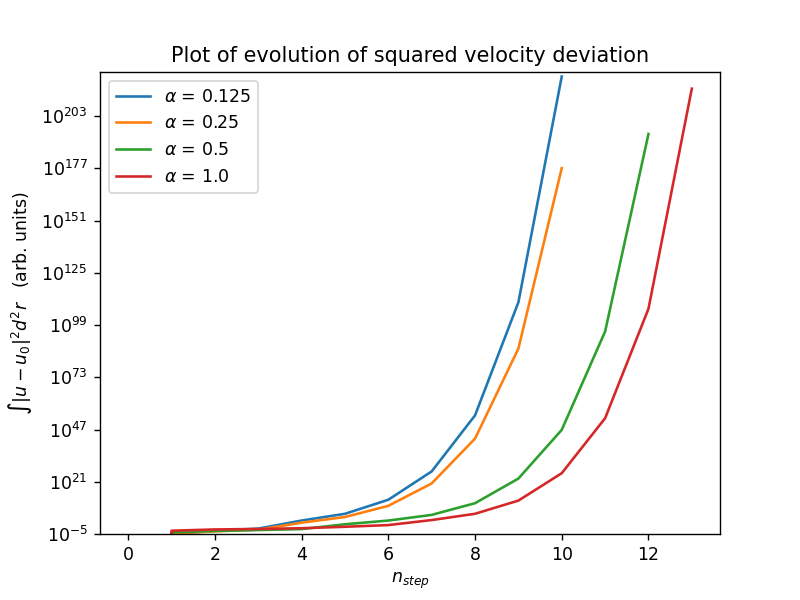

In [30]:
from ssmoke.polytrope2d import Polytrope2D
import warnings

n_steps = 20
dt = 0.01
alphas_to_test = (0.125, 0.25, 0.5, 1.0)
results = []

for alpha in alphas_to_test:
    integrator = Polytrope2D((Nx, Ny), (dx, dy), alpha, True, np.array([ux, uy, p]))
    deviations = [0.0,]
    with warnings.catch_warnings():
        warnings.simplefilter('error') # Upgrade RuntimeWarnings to exceptions
        for step in range(n_steps):
            try:
                integrator.advance_timestep(dt)
                fieldx, fieldy = integrator.flow_vel()
                deviations.append(dx * dy * np.sum((fieldx - ux)**2 + (fieldy - uy)**2))
            except:
                print('alpha = {} terminated early at step {} due to RuntimeWarning.'.format(alpha, step))
                break
    results.append(deviations)

for i in range(len(alphas_to_test)):
    plt.plot(results[i], label=r'$\alpha$ = {}'.format(alphas_to_test[i]))
plt.legend()
plt.xlabel(r'$n_{step}$')
plt.ylabel(r'$\int |u - u_0|^2d^2r\;\;$ (arb. units)')
plt.ylim((1e-5,1e+225))
plt.yscale('log')
plt.title(r'Plot of evolution of squared velocity deviation')
plt.show()

The source code for the `Polytrope2D` integrator can be found in the `ssmoke/polytrope2d.py` module.

It can be seen that, as $\alpha$ approaches zero, the simulation becomes increasingly divergent; in fact, none of the simulations are able to proceed beyond the 13<sup>th</sup> step due to numerical overflow. Although setting $\alpha \rightarrow 0^+$ does mathematically enforce ${\nabla\cdot\textbf{u}=0}$ in the analytic solution, this does not reflect correctly in the numerical solution. Rather, the behaviour of the fluid becomes increasingly dominated by sound waves, which introduce greater and greater numerical inaccuracies as amplified by the ${1/\alpha}$ term. As a result, this model always diverges, and cannot be used to simulate IIF.

We can extend this statement beyond just the polytrope: in general, for any barotropic fluid with a density-pressure relationship $\rho(p)$, the limit towards incompressibility always results in direct integration being numerically unstable for non-trivial initial conditions. This can be seen from the mass conservation condition:

$$
\nabla\cdot\left(\rho\textbf{u}\right) \;=\; -\,\frac{\partial\rho}{\partial t} \qquad\longrightarrow\qquad \frac{\partial p}{\partial t} \;=\; -\,\textbf{u}\cdot\nabla p \,-\, \rho(p)\left(\frac{d\rho}{dp}\right)^{-1}\nabla\cdot\textbf{u}
$$

hence sound waves always dominate in the incompressible limit ${\frac{d\rho}{dp} \rightarrow 0}$. We further propose, albeit with no proof, that this divergence generally occurs for any kind of weakly-compressible fluid (even if not barotropic) due to the increasing stiffness of the acoustic term.

<a id="sec12"></a>
### 1.2. Velocity-Projection Methods

It is clear, then, that any explicit calculation of the time evolution of pressure in IIF will result in numerical instability. Rather, pressure must be treated as a "magic" constraint, in the sense that:

<a id="eqn3"></a>
$$
\frac{\partial\textbf{u}}{\partial t} \;=\; -\,\left(\textbf{u}\cdot\nabla\right)\textbf{u}\,+\,\textbf{f}(t, \textbf{r}, \textbf{u})\tag{3}
$$

where ${\textbf{f} = -\nabla p}$ is a conservative vector field that exactly enforces ${\nabla\cdot\textbf{u}=0}$. Note, however, that the left-hand side of [eqn. (3)](#eqn3) is purely solenoidal, while the right-hand side contains a purely irrotational term ${\textbf{f}}$ and a general term ${\left(\textbf{u}\cdot\nabla\right)\textbf{u}}$. Appealing to Helmholtz's theorem (regarding the decomposition of any vector field into its irrotational and solenoidal parts), we can imagine that:

* ${\textbf{u}}$ evolves according to only the solenoidal part of ${\left(\textbf{u}\cdot\nabla\right)\textbf{u}}$.


* ${\textbf{f}}$ exactly cancels out the irrotational part of ${\left(\textbf{u}\cdot\nabla\right)\textbf{u}}$.

which therefore reduces the numerical problem to only one vector field. Strictly speaking, this does not hold absolutely true; the Helmholtz decomposition is only unique for smooth, rapidly-decaying, three-dimensional vector fields with certain boundary conditions chosen.<sup>[[5]](#ref05)</sup> Nonetheless, this idea can be used to generate approximate solutions under 'well-behaved' conditions, and remains the key idea to most Eulerian simulations of IIF (particularly when the explicit value of the pressure field itself is not of importance, e.g. in visual graphics).

<a id="sec121"></a>
#### 1.2.1. Stam's Method

This subsection introduces a algorithm developed by [[Stam 1999]](#ref04), although both the theory and the implemetation presented in this report differ from the original. It is based on the assumption that, for a well-behaved fluid with everywhere-smooth pressure, the pressure gradient should never dominate over the advection term:

<a id="eqn4"></a>
$$
\textbf{u}(t+dt) \quad\approx\quad \textbf{u}(t) \;-\; \underbrace{\left[\left(\textbf{u}\cdot\nabla\right)\textbf{u}\right]}_\text{almost solenoidal} dt \;-\; \underbrace{\left[\,\nabla p\,\right]}_\text{small}\; dt \tag{4}
$$

hence a purely advected field is already a good approximation to the IIF (for a sufficiently small timestep). Then, by choosing some suitable set of solenoidal basis functions, we can project the approximation to this basis in order to obtain the "closest" exactly solenoidal solution, therefore enforcing the necessary constraint. The algorithm can be summarized as follows:

1. Pure advection: ${\quad\textbf{v}'(t + dt) \;:=\; \textbf{u}(t) \,-\, \left[\left(\textbf{u}\cdot\nabla\right)\textbf{u}\right] dt}$


2. Projection: ${\qquad\;\;\,\textbf{u}(t + dt) \;\;=\;\; \text{ProjectToSolenoidal}(\textbf{v}')}$

In the case of periodic boundary conditions, the projection onto a solenoidal basis can be carried out particularly efficiently via the use of the Fourier transform. Defining ${\tilde{\textbf{u}}(t,\textbf{k})}$ as the Fourier transform of ${\textbf{u}(t, \textbf{r})}$, we see that ${\tilde{\textbf{u}}}$ must satisfy ${\textbf{k}\cdot\tilde{\textbf{u}}=0}$, hence the projection can be satisfied by:

$$
\tilde{\textbf{u}}(t,\textbf{k}) \;=\; \tilde{\textbf{v}}'(t,\textbf{k}) \,-\, \frac{1}{k^2}\left(\textbf{k}\cdot\tilde{\textbf{v}}' \right)\textbf{k}
$$

which can be easily inverse transformed.

We can further suppress the nonlinearity of the ${\left[\left(\textbf{u}\cdot\nabla\right)\textbf{u}\right] dt}$ term by noting that it is an advection-transport of the velocity field itself; in other words, we may use the approximation ${\textbf{v}'(t + dt, \textbf{r})\approx\textbf{u}(t, \textbf{r} - \textbf{u}\, dt)}$, which is a strictly linear computation with guaranteed stability. The error of this particular approximation scales with the curvature of the flow, ${\nabla^2\textbf{u}}$.

We may test Stam's method by applying to the same initial conditions tested in [section 1.1](#sec11):

In [3]:
from IPython.display import Video
Video('./report/Stam2DVortices.mp4')

We may even test the method on initially 'unphysical' cases, such as the demonstration below, which starts with two cylinders of the fluid moving towards each other (with infinite velocity gradients at their edges):

In [4]:
Video('./report/Stam2DCylinders.mp4')

The source code for the `Stam2D` integrator can be found in the `ssmoke/stam2d.py` module.

This time, the integrator is able to handle both cases robustly without diverging, even when infinite velocity gradients are present (e.g. in the second case). However, we see that the flows decay and lose energy over time; in particular it is the curl of the flow (the 'vorticity') which decays exponentially. This is caused by the linear advection-transport step ${\textbf{v}'(t + dt, \textbf{r})\approx\textbf{u}(t, \textbf{r} - \textbf{u}\, dt)}$, which introduces an error proportional to ${\nabla^2 \textbf{u}}$ – exactly like the viscosity term in the Navier-Stokes equation. In other words, the numerical error of the algorithm, particularly at regions of high flow curvature, acts as if there is an artificial 'viscosity' in the fluid.

Stam's method is thus not suitable for flows that are characterized by strong vorticities (e.g. turbulence), since this artificial viscosity will damp out such flows.

Many improvements over Stam's method have been proposed by multiple authors, which typically introduce an explicit vorticity-carrying term to prevent this energy-loss mechanism. (Examples: [[Zhang et al. 2015]](#ref06), [[Weißmann & Pinkall 2010]](#ref07).) While these methods generally improve upon the 'realism' of the generated flow without compromising numerical stability, they also introduce additional complexity to the algorithm. Ultimately, none are as computationally attractive as the recently-proposed "Schrödinger's Smoke", which we detail in this report.

<a id="sec2"></a>
## 2. Schrödinger's Smoke in Simple Cases

The "Schrödinger's Smoke" algorithm, developed by [[Chern et al. 2016]](#ref03), is a purely Eulerian and unconditionally stable method of simulating an IIF. In it, the fluid state is represented by a ${\mathbb{C}^2}$ wavefunction evolving under the Schrödinger equation with incompressibility constraints; the underlying Hamiltonian structure thus enforces energy conservation. The form of the Schrödinger equation allows for split-step integration to be used, thus keeping the algorithm simple and efficient.

<a id="sec21"></a>
### 2.1. Mathematical Background

We introduce a two-component wavefunction ${\psi = \left(\psi_1, \psi_2\right)^\top: \mathbb{R}\times\mathcal{M}\rightarrow\mathbb{C}^2}$ which maps a time $t$ and point ${\textbf{r}\in\mathcal{M}}$ to two complex numbers ${\psi_1, \psi_2}$. Defining the Hermitian product of two such wavefunctions as ${\langle\psi |\phi\rangle =\psi_1^*\phi_1 +\psi_2^*\phi_2}$, we may interpret the classical fluid state from $\psi$ as:

$$
\rho \;=\; |\psi|^2 \;=\; \langle\psi | \psi\rangle\; ,\qquad\rho\textbf{u} \;=\; -\,\hbar\,\text{Im}\big\{\langle\nabla \psi | \psi\rangle \big\}
$$

in which case the *incompressible Schrödinger flow* is governed by the time-evolution equation:

<a id="eqn5"></a>
$$
i \hbar \frac{\partial \psi}{\partial t} \;=\; -\,\frac{\hbar^2}{2}\nabla^2\psi \,+\, p\,\psi \tag{5}
$$

subject to the constraints ${\langle\nabla^2 \psi | \psi\rangle\in\mathbb{R}}$ and ${|\psi |^2 = 1}$. Here $p$ is again the pressure, a scalar field which maintains the zero-divergence constraint, which we will satisfy using the same method as in [section 1.2](#sec12). For now $\hbar$ is an arbitrary parameter, which represents the scaling of the physical field ${\textbf{u}}$ against $\psi$, but in the discrete case it will acquire another interpretation. We can show that a solution of [eqn. (5)](#eqn5) under such constraints is equivalently a solution of [eqns. (1)](#eqn1), and therefore a valid representation of IIF:

$$
\begin{split}
\frac{\partial \textbf{u}}{\partial t}\; & =\; -\,\hbar\,\text{Im}\Bigg\{\bigg\langle\nabla\frac{\partial\psi}{\partial t} \bigg|\; \psi\bigg\rangle\,+\,\bigg\langle\nabla\psi \,\bigg| \frac{\partial\psi}{\partial t}\bigg\rangle\Bigg\}
\\ & =\; -\,\hbar\,\text{Im}\Bigg\{\bigg\langle\frac{i\hbar}{2}\nabla\left(\nabla^2 \psi\right) - \frac{i\psi}{\hbar}\nabla p - \frac{ip}{\hbar}\nabla\psi \;\bigg|\; \psi\bigg\rangle\,+\,\bigg\langle\nabla\psi \,\bigg| \,\frac{i\hbar}{2}\nabla^2 \psi - \frac{ip\psi}{\hbar}\bigg\rangle\Bigg\}
\\ & =\; -\,\hbar\,\text{Im}\Bigg\{-\frac{i\hbar}{2}\langle\,\nabla (\nabla^2\psi )\, |\, \psi\,\rangle\,+\frac{i}{\hbar}\nabla p\,\langle\psi |\psi\rangle\,+\frac{ip}{\hbar}\langle\nabla\psi |\psi\rangle\,+\frac{i\hbar}{2}\langle\nabla\psi |\nabla^2\psi\rangle\,-\frac{ip}{\hbar}\langle\nabla\psi |\psi\rangle\Bigg\}
\\ & =\; -\,\hbar\,\text{Re}\Bigg\{-\frac{\hbar}{2}\langle\,\nabla (\nabla^2\psi )\, |\, \psi\,\rangle\,+\frac{1}{\hbar}\nabla p\, |\psi |^2\,+\frac{\hbar}{2}\langle\nabla\psi |\nabla^2 \psi\rangle\Bigg\}
\\ & =\; \frac{\hbar^2}{2}\,\text{Re}\bigg\{\langle\,\nabla (\nabla^2\psi )\, |\, \psi\,\rangle\,-\,\langle\nabla\psi |\nabla^2 \psi\rangle\bigg\}\;-\;\nabla p\; ;
\\ \\
\left(\textbf{u}\cdot\nabla\right)\textbf{u}\; & =\; \textbf{e}_i \; u_j \frac{\partial u_i}{\partial x_j}
\\ & =\; \textbf{e}_i \; \Bigg(-\hbar\,\text{Im}\Bigg\{\bigg\langle \frac{\partial\psi}{\partial x_j}\bigg|\; \psi\bigg\rangle\Bigg\}\Bigg)\;\frac{\partial}{\partial x_j}\Bigg[-\hbar\,\text{Im}\Bigg\{\bigg\langle \frac{\partial\psi}{\partial x_i}\bigg|\; \psi\bigg\rangle\Bigg\}\Bigg]
\\ & =\; \hbar^2 \textbf{e}_i \; \text{Im}\Bigg\{\bigg\langle \frac{\partial\psi}{\partial x_j}\bigg|\; \psi\bigg\rangle\Bigg\}\;\text{Im}\Bigg\{\bigg\langle \frac{\partial^2 \psi}{\partial x_i \partial x_j}\bigg|\; \psi\bigg\rangle\,+\,\bigg\langle \frac{\partial\psi}{\partial x_i}\bigg|\, \frac{\partial\psi}{\partial x_j}\bigg\rangle\Bigg\}
\\ & =\; \frac{\hbar^2}{2} \textbf{e}_i \; \text{Re}\Bigg\{\Bigg(\bigg\langle \psi\;\bigg|\, \frac{\partial\psi}{\partial x_j}\bigg\rangle\,-\,\bigg\langle \frac{\partial\psi}{\partial x_j}\bigg|\; \psi\bigg\rangle\Bigg)\Bigg(\bigg\langle \frac{\partial^2 \psi}{\partial x_i \partial x_j}\bigg|\; \psi\bigg\rangle\,+\,\bigg\langle \frac{\partial\psi}{\partial x_i}\bigg|\, \frac{\partial\psi}{\partial x_j}\bigg\rangle\Bigg)\Bigg\}
\\ & =\; \frac{\hbar^2}{2} \; \text{Re}\Bigg\{\bigg\langle\psi\;\bigg|\,\frac{\partial\psi}{\partial x_j}\bigg\rangle\bigg\langle\nabla\frac{\partial\psi}{\partial x_j}\bigg|\;\psi\bigg\rangle\,+\,\bigg\langle\psi\;\bigg|\,\frac{\partial\psi}{\partial x_j}\bigg\rangle\bigg\langle\nabla\psi\;\bigg|\,\frac{\partial\psi}{\partial x_j}\bigg\rangle\,-\,\bigg\langle\frac{\partial\psi}{\partial x_j}\,\bigg|\;\psi\bigg\rangle\bigg\langle\nabla\frac{\partial\psi}{\partial x_j}\bigg|\;\psi\bigg\rangle\,-\,\bigg\langle\frac{\partial\psi}{\partial x_j}\,\bigg|\;\psi\bigg\rangle\bigg\langle\nabla\psi\;\bigg|\,\frac{\partial\psi}{\partial x_j}\bigg\rangle\Bigg\}
\\ & =\; \frac{\hbar^2}{2} \; \text{Re}\bigg\{\,-\,\langle\psi|\nabla^2\psi\rangle\langle\nabla\psi|\psi\rangle \,-\,\langle\psi|\psi\rangle\langle\nabla(\nabla^2\psi)|\psi\rangle \,+\, \langle\psi|\nabla^2\psi\rangle\langle\nabla\psi|\psi\rangle \,+\, \langle\psi|\psi\rangle\langle\nabla\psi|\nabla^2\psi\rangle\bigg\}
\\ & =\; \frac{\hbar^2}{2}\,\text{Re}\bigg\{\,-\,\langle\,\nabla (\nabla^2\psi )\, |\, \psi\,\rangle\,+\,\langle\nabla\psi |\nabla^2 \psi\rangle\bigg\}\; ;
\\ \\
\therefore\frac{\partial \textbf{u}}{\partial t}\; & =\;-\,\left(\textbf{u}\cdot\nabla\right)\textbf{u}\,-\,\nabla p .
\end{split}
$$
<br>

The derivation above assumes that both constraints are held. The advantage of this wavefunction representation lies in the linear evolution term ${-\frac{\hbar^2}{2}\nabla^2 \psi}$, replacing the otherwise nonlinear advective term ${\left(\textbf{u}\cdot\nabla\right)\textbf{u}}$, which can be integrated exactly. Furthermore, the Hamiltonian ${\hat{\mathcal{H}} = -\frac{\hbar^2}{2}\nabla^2 + p = \frac{1}{2} u^2 + p}$ is implicitly conserved by the Schrödinger equation, thus guaranteeing conservation of energy. (In practice, however, some energy may be lost (or gained) in a numerical simulation, because this conservation is only implicit and thus subject to accumulating numerical errors.)

Technically, [eqn. (5)](#eqn5) and its proof can apply to a single-component wavefunction ${\psi\in\mathbb{C}}$; in other words, a single complex scalar field is sufficient to generate a valid solution to IIF. However, this is not sufficient to fully describe all phenomena of interest, for the following reason. Such a single-component wavefunction may generally be described by a single real scalar field ${\psi(\textbf{r}) = e^{\,i\alpha(\textbf{r})}}$, up to a global phase symmetry, in which case the flow velocity reduces to:

$$
\begin{split}
\textbf{u} \;=\; -\,\hbar\,\text{Im}\big\{\langle\nabla \psi | \psi\rangle \big\} \; & =\; -\,\hbar\,\text{Im}\big\{\langle\, i e^{\, i\alpha} (\nabla \alpha) \;|\; e^{\, i\alpha}\,\rangle \big\}
\\ & =\; -\,\hbar\,\text{Im}\big\{- i e^{-i\alpha} e^{\, i\alpha}\,(\nabla \alpha) \big\}\;=\;\hbar\nabla\alpha
\end{split}
$$

i.e. purely potential flow, with strictly irrotational velocity. While it is nonetheless a valid solution to IIF, such potential flows are already very well-studied, and frankly not of interest in this report. On the other hand, two components of $\psi$ are sufficient to reproduce vorticity. A two-component wavefunction subject to the necessary constraints can, in general, be expressed by three real scalar fields (again up to a global phase symmetry):

<a id="eqn6"></a>
$$
\begin{cases} \;\;\psi_1 \;=\; \cos(\theta(\textbf{r}))\; e^{\, i\alpha_1(\textbf{r})}\; , \\[5pt] \;\;\psi_2 \;=\; \sin(\theta(\textbf{r}))\; e^{\, i\alpha_2(\textbf{r})}\; ; \end{cases}\tag{6}
$$

in which case the flow velocity and its curl are:

<a id="eqn7"></a>
$$
\begin{split}
\textbf{u} \; & =\; -\,\hbar\,\text{Im}\big\{(\nabla \psi_1)^*\psi_1 \,+\, (\nabla \psi_2)^*\psi_2\big\}
\\ & =\; \hbar\left(\cos^2\theta\;\nabla\alpha_1\,+\,\sin^2\theta\;\nabla\alpha_2\right)\; ;
\end{split}
$$

$$
\nabla\times\textbf{u} \;=\; \hbar \sin(2\theta) \; (\nabla\theta)\times(\nabla\alpha_2 \,-\,\nabla\alpha_1)\qquad \tag{7}
$$

which is generally non-zero, and may permit a rich structure of vorticity.

<a id="sec22"></a>
### 2.2. The Algorithm

Applying the ideas discussed in [section 1.2.1](#sec121), the constraint field $p$ can be resolved by enforcing the relevant constraints via projection between evolution timesteps; the algorithm can thus be summarized as:

1. Evolve according to ${\;\dfrac{\partial\psi}{\partial t} = \dfrac{i\hbar}{2}\nabla^2 \psi}$.


2. Enforce ${\;|\psi|^2 = 1}$.


3. Enforce ${\;\nabla\cdot\text{Im}\big\{\langle\nabla\psi |\psi\rangle\big\} = 0}$.

The first step can be achieved exactly using split-step integration. Where ${\tilde{\psi}(t, \textbf{k})}$ is the Fourier transform of ${\psi(t, \textbf{r})}$, a timestep $dt$ evolves the wavefunction by a simple phase shift:

<a id="eqn8"></a>
$$
\frac{\partial\tilde{\psi}}{\partial t} \;=\; -\frac{i\hbar}{2}k^2 \tilde{\psi} \qquad\rightarrow\qquad \tilde{\psi}(t+dt, \textbf{k}) \;=\; e^{-i\frac{\hbar k^2}{2} dt}\;\tilde{\psi}(t, \textbf{k})\tag{8}
$$

Although this theoretically preserves the magnitude ${|\psi|}$ of the wavefunction, small numerical errors may creep in, hence the enforcement of ${|\psi| = 1}$ is still necessary; nonetheless the second step is trivial, with the constraint being enforced by normalization ${\psi \mapsto \psi\, /\, |\psi|}$.

The last step is somewhat trickier, but can be achieved by projecting the wavefunction onto the 'closest' wavefunction satisfying the constraint. Let ${\psi_0(\textbf{r})}$ be a wavefunction which satisfies ${|\psi_0| = 1}$ but not necessarily ${\langle\nabla^2\psi_0 |\psi_0\rangle\in\mathbb{R}}$, and let ${\psi_{proj}(\textbf{r})}$ be a wavefunction which satisfies both constraints; noting that both wavefunctions have a global phase shift symmetry, the 'simplest' transformation between the two wavefunctions which correctly preserves the norm and respects the phase symmetry is that of a "gauge transformation":

<a id="eqn9a"></a>
$$
\psi_{proj}(\textbf{r}) \; =\; e^{\, i q(\textbf{r})}\;\psi_0(\textbf{r})\; \tag{9a}
$$

where the real scalar field ${q(\textbf{r})}$ obeys:

$$
\begin{split}
\langle\,\nabla^2\psi_{proj}\,|\,\psi_{proj}\,\rangle \; & =\;\big\langle\,\nabla^2(e^{\, iq}\,\psi_0)\,\big|\,e^{\, iq}\,\psi_0\,\big\rangle
\\ & =\;\big\langle\, i(\nabla^2 q) e^{\,iq}\psi_0 \,-\, |\nabla q|^2 e^{\,iq}\psi_0 \,+\, 2i e^{\,iq} (\nabla q \cdot \nabla \psi_0) \,+\, e^{\,iq}\nabla^2 \psi_0 \;\big|\;e^{\, iq}\,\psi_0\,\big\rangle
\\ & =\; -\,i\nabla^2 q \,-\,|\nabla q|^2 \,-\, 2i(\nabla q)\cdot\langle\nabla\psi_0 | \psi_0\rangle \,+\, \langle \nabla^2\psi_0 | \psi_0\rangle\; ;
\\ \\ \text{Im}\big\{\langle\,\nabla^2\psi_{proj}\,|\,\psi_{proj}\,\rangle\big\}\; & =\; 0 \;=\; -\,\nabla^2 q \,-\, 2\nabla q\cdot\text{Re}\big\{\langle\,\nabla\psi_0\,|\,\psi_0\,\rangle\big\} + \text{Im}\big\{\langle\,\nabla^2\psi_0\,|\,\psi_0\,\rangle\big\}\; .
\end{split}
$$
<br>

However, note that ${2\text{Re}\{\langle\nabla\psi_0 | \psi_0\rangle\} = \langle\nabla\psi_0 | \psi_0\rangle+\langle\psi_0 | \nabla\psi_0\rangle = \nabla \langle\psi_0 |\psi_0\rangle = 0}$ by normalization constraint, hence the middle term must be zero. This gives ${q(\textbf{r})}$ in terms of a Poisson equation:

<a id="eqn9b"></a>
$$
\nabla^2 q \;=\; \text{Im}\big\{\langle\,\nabla^2\psi_0\,|\,\psi_0\,\rangle\big\} \tag{9b}
$$

which can similarly be solved by spectral methods, or by integrating the Green's function.

<a id="sec221"></a>
#### 2.2.1. Implementation

In the specific case of a two-dimensional system with periodic boundary conditions, we may discretize the ${\textbf{r}}$-space into a ${N_x\times N_y}$ grid of cell dimensions ${(dx, dy)}$, and discretize time into timesteps $dt$. In that case $\psi$ may be stored as a pair of complex numbers for every cell, and evolved according to the following pseudocode:

$$
\begin{align}
&\qquad\qquad\qquad&&\qquad\qquad\qquad\qquad\qquad&&\text{def divergence_constraint():}\\
&\text{def advance_timestep(dt):}\qquad &&\text{def time_evolution(dt):}&&\qquad\mathcal{E}\leftarrow\text{Im}\{\langle\nabla^2\psi | \psi\rangle\}\\
&\qquad\psi\leftarrow\text{time_evolution(dt)}&&\qquad\tilde{\psi}\leftarrow\text{FFT}(\psi)&&\qquad\tilde{\mathcal{E}}\leftarrow\text{FFT}(\mathcal{E})\\
&\qquad\psi\leftarrow\psi\,/\,|\psi|&&\qquad\tilde{\psi}\leftarrow e^{-i\frac{\hbar k^2}{2} dt}\tilde{\psi}&&\qquad\tilde{q}\leftarrow -\,\tfrac{1}{k^2}\tilde{\mathcal{E}}\\
&\qquad\psi\leftarrow\text{divergence_constraint()}&&\qquad\psi\leftarrow\text{IFFT}(\tilde{\psi})&&\qquad q\leftarrow\text{IFFT}(\tilde{q})\\
& && &&\qquad\psi\leftarrow e^{\, iq}\psi
\end{align}
$$

The efficiency of this algorithm stems from the efficiency of the fast Fourier transform, giving the overall asymptotic time complexity for processing a single timestep $dt$ to be ${O(N_xN_y\log_2(N_xN_y))}$ unconditionally. Furthermore, the linearity of every operation, combined with the enforcement of normalization, ensures that the computation will not diverge – as long as the divergence ${\mathcal{E}}$ is **not** calculated 'naïvely' using a second-order finite difference method (which may fail for large velocity gradients).

<a id="sec222"></a>
#### 2.2.2. Calculation of Divergence without Finite Difference Method

Regarding the calculation of the divergence ${\mathcal{E}=\text{Im}\{\langle\nabla^2\psi | \psi\rangle\}}$, the discretization of the space allows for a more stable approach to be taken. Consider a cell at position ${\textbf{r}}$; we wish to calculate ${\mathcal{E}(\textbf{r})=\nabla\cdot\text{Im}\{\langle\nabla\psi(\textbf{r}) | \psi(\textbf{r})\rangle\}}$ at the cell, which is simply the sum of all flows from the neighbouring cells:

<a id="eqn10a"></a>
$$
\mathcal{E}(\textbf{r}) \;\approx\; \frac{1}{V(\textbf{r})}\sum_{\textbf{r}'\,\in\,\mathcal{N}} \frac{A(\textbf{r}, \textbf{r}')}{|\textbf{r}' - \textbf{r}|}(\textbf{r}' - \textbf{r})\cdot\,\text{Im}\big\{\langle\nabla\psi(\textbf{r}') | \psi(\textbf{r}')\rangle\,-\,\langle\nabla\psi(\textbf{r}) | \psi(\textbf{r})\rangle\big\}\tag{10a}
$$

where ${\mathcal{N}}$ is the set of all neighbouring cells, ${V(\textbf{r})}$ is the volume of the cell, and ${A(\textbf{r}, \textbf{r}')}$ is the shared face area between the neighbouring cells. Writing ${d\textbf{r}=\textbf{r}'-\textbf{r}}$, and using the general expression for the two-component wavefunction given by [eqn. (6)](#eqn6), the first-order Taylor expansion for the right-hand term within the sum is:

$$
\begin{align}
d\mathbf{r}\cdot\,\text{Im}\big\{\langle\nabla\psi(\textbf{r}') | \psi(\textbf{r}')\rangle\,-\,\langle\nabla\psi(\textbf{r}) | \psi(\textbf{r})\rangle\big\} \; & \approx\; d\mathbf{r}\cdot\text{Im}\big\{\,-\,i\cos^2\theta\,\nabla\alpha_1\,-\,i\sin^2\theta\,\nabla\alpha_2\,\big\}
\\ & =\; -\,\cos^2\theta\,d\alpha_1\,-\,\sin^2\theta\,d\alpha_2
\end{align}
$$

but this is equivalent to the complex argument of ${\langle\,\psi(\textbf{r})\,|\,\psi(\textbf{r} + d\textbf{r})\,\rangle}$. Hence we may replace the potentially numerically unstable derivatives in [eqn. (10a)](#eqn10a) with a more benign calculation:

<a id="eqn10b"></a>
$$
\mathcal{E}(\textbf{r}) \;\approx\; \frac{1}{V(\textbf{r})}\sum_{\textbf{r}'\,\in\,\mathcal{N}} \frac{A(\textbf{r}, \textbf{r}')}{|\textbf{r}' - \textbf{r}|}\,\text{arg}\big\{\langle\psi(\textbf{r}) | \psi(\textbf{r}')\rangle\big\}\tag{10b}
$$

Although the proof provided here only demonstrates the equivalence of this approximation at first order, the original proof provided in [[Chern et al. 2016]](#ref03) proves that this calculation is exact to all orders, by integrating along a geodesic of the analytic extension.

<a id="sec23"></a>
### 2.3. Initial Conditions

We can take advantage of the symmetry of [eqn. (5)](#eqn5) under unitary transformations of $\psi$; when initializing a flow state, it is often helpful to set ${\psi_2 = 0}$ and then initialize ${\psi_1}$ to the desired state. (In practice ${\psi_2 = \epsilon = 0.01}$ is used instead, in order to guard against zeros in ${\psi_1}$ after the first timestep – see two paragraphs down.) It should be stressed that this is not the same as forcing ${\psi}$ to act as a single-component wavefunction, since we may set an initially discontinuous ${\psi_1}$, which will then resolve on the first timestep; hence we are capable of initializing flows with non-zero curl, although it is true that the initial state is locally curl-free everywhere except at discontinuities.

A particularly useful construction is to set a plane wave within some region $\Omega$:

$$
\psi_1(t=0,\textbf{r}\in\Omega) \;=\; e^{\, i\frac{1}{\hbar}\textbf{v}\cdot\textbf{r}} 
$$

which generates a uniform flow ${\textbf{u}(\textbf{r}) = \textbf{v}}$ everywhere in $\Omega$. By choosing an appropriate set of piecewise $\Omega$ and $\textbf{v}$, the initial flow may be 'coerced' into any desired structure upon the first timestep, even despite the restriction of locally zero curl within $\Omega$. For example, a closed vortex ring (in three dimensions) can be created by extruding the enclosed area and then initializing a (possibly non-uniform) velocity perpendicular to the Seifert surface; the enforcement of the divergence constraint will 'compile' this flow into the correct vorticity structure upon the first timestep. This mechanism is caused by the initially small but non-zero value of ${\psi_2}$, which, upon the normalization on the first timestep, is suppressed to zero at the initially uniform regions (since the divergence constraint will leave ${\psi_1}$ significant there), and greatly magnified near the curl-inducing discontinuities.

It should be noted that, under periodic boundary conditions, the net vorticity in the system must be zero for any number of dimensions. This is easily proven by integrating the flow velocity along a closed contour around the boundary. The consequence is that, in three dimensions, the simulation is only capable of producing closed vortex loops, and in two dimensions vorticity must always exist in opposing pairs.

In the example below, the opposing vortices were initialized by creating rectangular regions of uniform flow:

In [5]:
Video('./report/SSmoke2DVortices.mp4')

The simulation is also able to capture the vortices produced by sharp edges, such as in the case of the cylinders of fluid moving towards each other:

In [6]:
Video('./report/SSmoke2DCylinders.mp4')

In [7]:
Video('./report/SSmoke2DCylindersParticles.mp4')

From these examples, we observe that the vorticity (curl of the flow velocity) has a tendency to concentrate into discrete elements of a certain magnitude, thus showing up as 'pixels' in the curl plot; each of these elements acts almost like an ideal vortex, and is carried along with the flow. Interestingly, adjusting the $\hbar$ parameter reveals that the magnitude of each of these vortex elements scales linearly with $\hbar$; to a rough approximation the curl reduces to:

$$
\nabla\times\textbf{u}(\textbf{r})\;\approx\;\begin{cases}0 & \text{if }\textbf{r}\text{ is not a vortex element}\\ 2\pi\hbar|d\textbf{r}|^{-1} & \text{if }\textbf{r}\text{ is a vortex element}\end{cases}
$$

Of course, this relationship is not exact, and the vorticity is not actually binary – the vortex elements do vary in strength. Nonetheless it is seen that each cell, at any given time, either has very small vorticity or otherwise has vorticity on the order of magnitude of ${\hbar/|d\textbf{r}|}$, thus giving a *pseudo-quantization* of vorticity. This gives $\hbar$ a special interpretation as the unit of quantization of vorticity over a discrete grid of cells.

The original paper [[3]](#ref03) provides a proof of why this vorticity quantization should be expected.

<a id="sec24"></a>
### 2.4. Relationship to Superfluid Dynamics

Superfluidity is a quantum mechanical phenomenon where a fluid is capable of flowing with zero bulk viscosity, typically by condensing into a macroscopic wavefunction; because the wavefunction must have a well-defined phase everywhere, vortices in a superfluid are topologically quantized such that the produced circulation is an integer multiple of ${2\pi\hbar/m}$.<sup>[[8]](#ref08)</sup> (These properties can be described by an effective field theory of massless phonons and massive rotons, emerging as the Nambu-Goldstone modes from a certain spontaneously broken symmetry; see ref. [[9]](#ref09).)

The behaviour of the "Schrödinger's Smoke" fluid is thus nearly exactly analogous to that of a superfluid. Indeed, as stated in the original paper, one of the primary inspirations for the algorithm and its evolution equation [(5)](#eqn5) was the Gross-Pitaevskii equation for describing the ground state of a superfluid. While the quantization of vorticity is not exact in the algorithm, the algorithm nonetheless provides an approximate representation of a superfluid, with the simulated fluid behaving very similarly.

<a id="sec3"></a>
## 3. Schrödinger's Smoke under Further Conditions

Practical usage of fluid dynamics simulations often involve domains of non-trivial geometry (e.g. flows around obstacles or objects), non-periodic boundary conditions, and/or external forces such as gravity. The "Schrödinger's Smoke" algorithm can be easily modified to add such considerations.

<a id="sec31"></a>
### 3.1. Velocity Constraints

A particularly useful space-dependent constraint is that of a fixed flow velocity $\textbf{v}$ in a region $\Omega$:

$$
\textbf{u}(t,\textbf{r}\in\Omega) \;=\; \textbf{v}\qquad\qquad\forall\; t\in\mathbb{R} 
$$

which, noting its similarity to the uniform-velocity initial condition described in [section 2.3](#sec23), is generally enforced by holding $\psi$ to a plane wave form, up to some arbitrary global phase and local 'direction':

$$
\psi(t,\textbf{r}\in\Omega) \;=\; \begin{pmatrix} \psi_1 \\[1pt] \psi_2 \end{pmatrix}_{\textbf{r}\,\in\,\Omega} \;=\;\; e^{\, i\frac{1}{\hbar}\textbf{v}\cdot\textbf{r}} \begin{pmatrix} ae^{\, i\phi} \\[1pt] be^{\, i\phi} \end{pmatrix} \qquad\forall\; t\in\mathbb{R}
$$

where $a$, $b$ are real scalar fields satisfying ${a^2 + b^2 = 1}$ and $\phi$ is a real phase constant. In other words, for all time, for all points in $\Omega$, we have ${\alpha_1(\textbf{r}) = \alpha_2(\textbf{r})}$ varying linearly in the same direction as ${\textbf{v}}$, as per a plane wave. This can be enforced by the iterative method of approximation, illustrated by the pseudocode below:

$$
\begin{align}
& \text{def velocity_constraint(}\textbf{v}, \Omega\text{):} \\
& \qquad\psi_1(\textbf{r}\in\Omega)\leftarrow e^{\, i\frac{1}{\hbar}\textbf{v}\cdot\textbf{r}}|\psi_1|\\
& \qquad\psi_2(\textbf{r}\in\Omega)\leftarrow e^{\, i\frac{1}{\hbar}\textbf{v}\cdot\textbf{r}}|\psi_2|\\
& \qquad\psi\leftarrow\text{divergence_constraint()}
\end{align}
$$

Every run of ${\text{velocity_constraint(}\textbf{v}, \Omega\text{)}}$ perturbs the solution towards the desired velocity within the region, without violating any of the other constraints; by repeatedly iterating through this process, we are guaranteed to converge towards a valid solution. In practice it is found that 10 iterations, performed at the end of the timestep, is sufficient to achieve realistic-looking results.

The example below demonstrates a flow past a stationary cylinder, at high Reynolds number; notice the vortex shedding from the boundary layer of the cylinder, resulting in flow separation and "suck-back" of the wake – a turbulent phenomenon which is difficult to capture via conventional simulations:

In [8]:
Video('./report/SSmoke2DStationaryCylinder.mp4')

There are some small 'vortex anomalies' which appear above and below the cylinder at the beginning of the simulation, caused by the initial enforcement of the constraint, which loop back around upon reaching the periodic boundaries and disturb the oncoming flow, but they are not significant.

The boundary layer of the stationary cylinder is effectively modeled by the one-gridcell-thick layer of vortices that must occur at the velocity discontinuity; this is what allows for realistic turbulent behaviour, such as vortex shedding or flow separation. Although the fluid has no true viscosity, the pseudo-quantized vortices allow for momentum exchange across the fluid, giving an effective definition for a *superfluid Reynolds number* of ${\text{Re}=uL\,/\,2\pi\hbar}$ where $u$ is the characteristic flow speed and $L$ is the characteristic length. The simulation above had ${\text{Re}\approx20}$.

Unfortunately, the pseudo-quantization of vorticity also means that the boundary layer fails to perfectly 'cancel out' all velocity inside the constraint region. Indeed, it was seen that some flow 'penetrates' into the stationary cylinder. Although the total flux of flow through the cylinder was (numerically close to) zero at all times, a weak but non-zero velocity field still occurs within the cylinder; that said, this field is not significant enough to influence the flow outside the region. This is an intentional trade-off of the approach taken by the Schrödinger's Smoke algorithm, in that velocity constraints are approximately but not exactly enforced.

<a id="sec32"></a>
### 3.2. Boundary Conditions

While the continuous forms of the wavefunction equations described in [section 2](#sec2) do not make any assumptions about the spatial domain ${\mathcal{M}}$ (other than being differentiable everywhere in the interior), the simplest implementation for a finite domain is to use periodic boundary conditions, so that the discrete Fourier transforms are exactly correct. This is because the discrete Fourier transform of a function over a finite domain is equivalent to the continuous Fourier transform of the periodic extension of the discretization of the function; the same applies to the inverse discrete Fourier transform.

<br><div><img src="report/dft_illustration.png" width=700/></div><br>

However, fully periodic boundary conditions rarely appear in realistic scenarios – use cases are limited to simulations of objects in a lattice, or (for periodicity in one direction) rotating fan blades etc.. Hence the algorithm should be extendable to other boundary conditions if it is to have good practicality, even if used only for graphics. A non-exhaustive list of useful boundary conditions is given below, noting that a domain can have a mixture of different boundary conditions:

| Boundary | Condition | Use case |
| :-: | :- | :- |
| Periodic | 'Physical' fields $\textbf{u}$ and $p$ are periodic | Periodic geometries |
| Symmetric | 'Physical' fields $\textbf{u}$ and $p$ are reflected across the boundary;<br>for signed distance from the boundary there can be either<br>odd or even symmetry independently for each of $p$, the<br>normal component of $\textbf{u}$, and the tangential component of $\textbf{u}$ | Symmetrical geometries |
| Open<br>(Const. pressure) | $p$ is constant (and 'ambient') across the boundary | Free flow |
| Closed<br>(Wall) | ${\textbf{u}\cdot\textbf{n}=0}$ for normal vector $\textbf{n}$ of the boundary | Confined flow; closed walls |
| Inlet/Outlet | A specified ${\textbf{u}(\textbf{r})}$ at the boundary | Inlets; outlets |
<br>

Symmetric boundary conditions can be enforced, for simple boundary geometries, by expanding the domain beyond the boundary and applying the method of images to create an overall periodic domain; for example, a one dimensional function $f(x)$ acting on the domain ${x\in(0,2)}$, satisfying some differential equation ${\mathcal{L}f=g}$ with even symmetry at ${x=2}$, is equivalent to the extended function $f'(x)$ acting on the domain ${x\in(0,4)}$ with periodicity ${f'(0)=f'(4)}$ (and appropriately extended $g$). This also gives the condition for the closed wall, which is simply an odd symmetry of the normal component of $\textbf{u}$. In practice for rectangular domains this can be implemented by replacing the FFT for $\psi$ in the time evolution step with either a discrete sine transform (DST) or a discrete cosine transform (DCT), depending on which type of symmetry is desired.

Open boundary conditions can also be enforced, by noting that the 'gauge field' $q$ in [eqn. (9)](#eqn9a) corresponds to the argument of the pressure term in [eqn. (5)](#eqn5). Hence, for ambient pressure at the boundary, the divergence constraint should not be enforced at the boundary, permitting fluid to enter or leave. This is equivalent to solving [eqn. (9b)](#eqn9b) using ${q=0}$ at the boundary; in practice this is achieved by replacing the FFT for $\mathcal{E}$ and $q$ with a DST.

An inlet or outlet can be easily simulated using a velocity constraint, backed by an open boundary.

The simulation below shows a Joukowski airfoil, stalled at an angle of attack of 20°, with an inlet on the left side (also covering the top and bottom sides) and open boundary conditions on the right side:

In [9]:
Video('./report/SSmoke2DAirfoil.mp4')

Some small artifacts are seen at the inlets (caused by the velocity constraints of the inlets not being fully converged), but they do not significantly affect the behaviour at the region of interest, near and immediately downstream of the airfoil. Although the general behaviour of the flow resembles reality, the flow speed does generally decay over time; this is caused by the difficulties encountered by the integrator in trying to resolve the velocity constraints together with the increasingly complex flow downstream.

This demonstrates a weakness of the Schrödinger's Smoke algorithm - although it is theoretically extensible to other boundary conditions, it may perform poorly, especially if extensive velocity constraints are necessary. Nonetheless, by setting the domain to be sufficiently large, one may still apply the algorithm on periodic boundary conditions to model most physical situations, as long as the timescale is also short enough that downstream effects do not 'loop' back upstream. The simulation below shows the same airfoil under the same initial conditions, but using a larger domain on fully periodic boundary conditions (and no velocity constraints other than the airfoil itself):

In [10]:
Video('./report/SSmoke2DAirfoilPeriodic.mp4')

<a id="sec33"></a>
### 3.3. External Forces

It is also useful to model the effects of external forces, such as gravity, on fluids. This is especially important for capturing certain phenomena, such as the motion of hot smoke in air, which is dominated by buoyancy. It should be noted that the Schrödinger's Smoke algorithm only simulates a single fluid, and cannot properly handle the two-fluid dynamics necessary for a proper description of buoyancy; nonetheless, for visual purposes, an artificial 'gravitational field' can be introduced to vortices, so as to generate realistic-looking (but not physically accurate) motion.

Because of the way $\psi$ is initialized (see [section 2.3](#sec23)), it is reasonable to describe $\psi_1$ as an indirect representation of the irrotational part of the flow, which is not affected by the artificial buoyancy, and $\psi_2$ as an indirect representation of the vorticity, which is 'carried' along by the gravitational field. Under a uniform gravitational field ${\textbf{g}}$ (for "heavy" smoke, which sinks in the direction of ${\textbf{g}}$), we can thus modify the evolution equation [(5)](#eqn5) to read:

$$
i \hbar \frac{\partial \psi}{\partial t} \;=\; -\,\frac{\hbar^2}{2}\nabla^2\psi \,+\, p\,\psi \,+\, \begin{pmatrix}0 & 0 \\ 0 & \textbf{g}\cdot\textbf{r}\end{pmatrix}\,\psi
$$

Algorithmically, this is simple to implement - a direct integration of the change in the $\psi_2$ component can be carried out every timestep, after normalization but before divergence constraint enforcement. Note that this modification strictly relies on the initialization conditions of [section 2.3](#sec23).

<a id="sec4"></a>
## 4. Schrödinger's Smoke in Three Dimensions

Of course, the vast majority of physically interesting scenarios where fluid simulations are of use tend to occur in three spatial dimensions; in fact, the original paper [[3]](#ref03) had considered three-dimensional flows only. This report focuses on two-dimensional flows purely to reduce the difficulties in selecting suitable testcases and visualizing the results, but nonetheless it is easy enough to implement the algorithm in three dimensions.

The testcase below shows two 'spheres' of fluid initially moving towards each other; the video shows a quiver plot of the vorticity ${\nabla\times\textbf{u}}$ (which is, obviously, a vector field in three dimensions), which visually resembles a particulate suspension (e.g. smoke) trapped along the vorticity lines:

In [11]:
Video('./report/SSmoke3DSpheres.mp4')

The 'thin cloud' that appears throughout the entire domain is simply noise, caused by the relatively small lattice size used here (200×100×100, as opposed to the ~400×200 used for the 2D simulations). Nonetheless we see correct physical phenomena occuring, including the general tendency for vorticity to self-organize into filamentary structures, the secondary vortex rings being ejected out of the back of the spheres at the beginning of the simulation and then being annihilated when they combine at the periodic boundary, the distortion of the main vortex rings immediately before collision, etc..

The application of velocity constraints is also identical to the 2D case, as demonstrated by this flow past a stationary spherical object (at ${\text{Re}\approx10}$):

In [12]:
Video('./report/SSmoke3DStationarySphere.mp4')

Unfortunately the small lattice size (with the sphere being only 25 voxels in diameter!) greatly amplifies the 'vortex anomalies' initially occurring on the cross-sectional plane of the sphere, which then collapse into significant structures; this anomalous structure exhibits a four-fold symmetry, stemming from the symmetry of the voxelization itself.

A further flaw in the video is caused by Matplotlib's weakness in performing 3D renders, specifically in its inability to resolve the rendering order for overlapping objects – an acknowledged fault of the mplot3d toolkit.<sup>[[10]](#ref10)</sup> As such the video wrongly displays the vorticity plot 'on top' of the stationary sphere, which makes the visualization confusing. Nonetheless we can see the formation of the thin boundary layer over the sphere, as well as the shedding of vortex rings from that boundary layer, similar to the demonstration in [section 3.1](#sec31). Again, the pseudo-quantization of vorticity results in some weak 'penetration' of velocity into the sphere, but nonetheless the behaviour outside the sphere is largely accurate.

<a id="sec5"></a>
## 5. Conclusion

The art of simulating an inviscid incompressible flow (IIF), in the Eulerian framework, cannot be approached by naïve integration techniques, and must be solved via constraint methods. However, poorly applied constraints may result in unphysical behaviour, such as energy decay.

The "Schrödinger's Smoke" algorithm is a robust and unconditionally stable simulation of IIF, with strong similarities in particular to superfluidity. It correctly simulates several complex and nontrivial phenomena such as vortex self-interactions and boundary layer separation, in a manner which correctly conserves overall momentum (explicitly, via eqn. [(5)](#eqn5)) and approximately conserves overall energy (implicitly, via the Hamiltonian). It has particular application in computer graphics, specifically for generating realistic-looking fluid behaviour, where the exact values of the pressure field and the physical interpretation of the $\hbar$ parameter are not of importance.

An acknowledged shortcoming of the "Schrödinger's Smoke" algorithm is its 'softness' in enforcing velocity constraints, allowing some velocity to leak into obstacles. This may be improved by imposing a higher-order integrator over the constraints to find an exact (or closer to exact) solution. The algorithm is also, at present, not able to handle external forces in general, other than the simplest case of a uniform gravitational field.

It may be interesting to extend the mathematical model over a multi-phase flow, e.g. to simulate the flow of water and air. This would be necessary for a proper treatment of buoyancy, and would also enable – if possible – a pathway towards stable simulations of multi-phase flows, which is currently considered difficult to simulate.

<a id="References"></a>
## References

<a id="ref01"></a>
[1] Hunter J.K. (2006). An introduction to the incompressible Euler equations. Accessed on 30 March 2023 at https://www.math.ucdavis.edu/~hunter/notes/euler.pdf30/03/2023.

<a id="ref02"></a>
[2] Gingold R.A., Monaghan J.J. (1977). Smoothed particle hydrodynamics: theory and application to non-spherical stars. *Monthly Notices of the Royal Astronomical Society*, vol. 181, issue 3, pp. 365-389. DOI: 10.1093/mnras/181.3.375.

<a id="ref03"></a>
[3] Chern A., Knöppel F., Pinkall U., Schröder P., Weißmann S. (2016). Schrödinger's Smoke. *ACM Transactions on Graphics*, vol. 35, issue 4, article 77, pp. 1-13. DOI: 10.1145/2897824.2925868.

<a id="ref04"></a>
[4] Stam J. (1999). Stable fluids. *SIGGRAPH '99: Proceedings of the 26th annual conference on Computer graphics and interactive techniques*, pp. 121-128. DOI: 10.1145/311535.311548.

<a id="ref05"></a>
[5] Bladel J. (1958). *On Helmholtz's Theorem in Finite Regions*. Midwestern Universities Research Association.

<a id="ref06"></a>
[6] Zhang X., Bridson R., Greif C. (2015). Restoring the missing vorticity in advection-projection fluid solvers. *ACM Transactions on Graphics*, vol. 34, issue 4, article 52, pp. 1-8. DOI: 10.1145/2766982.

<a id="ref07"></a>
[7] Weißmann S., Pinkall U. (2010). Filament-based smoke with vortex shedding and variational reconnection. *ACM Transactions on Graphics*, vol. 29, issue 4, article 115, pp. 1-12. DOI: 10.1145/1778765.1778852.

<a id="ref08"></a>
[8] Thuneberg E.V. (2005). Superfluidity. In: Bassani F., Liedl G.L., Wyder P. (1<sup>st</sup> ed.). *Encyclopedia of Condensed Matter Physics* (pp. 128-133). Elsevier.

<a id="ref09"></a>
[9] Matchev K., Smolinsky J. Xue W., You Y. (2022). Superfluid effective field theory for dark matter direct detection. *Journal of High Energy Physics*, article 34. DOI: 10.1007/JHEP05(2022)034.

<a id="ref10"></a>
[10] mplot3d FAQ, Matplotlib documentation. Accessed on 11 April 2023 at https://matplotlib.org/stable/api/toolkits/mplot3d/faq.html#toolkit-mplot3d-faq.